## Imports

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from tensorflow_model_optimization.python.core.keras.compat import keras


from scipy.stats import spearmanr

from copy import deepcopy

In [14]:
np.set_printoptions(suppress=True)

## Data Preparation

In [15]:
# Import the data

data = pd.read_csv("data/stress_factors.csv")


In [16]:
# Create factorized version
# One-hot encode the categorical columns
data_encoded = pd.get_dummies(data, drop_first=True)

# Standardize the data (important for PCA)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_encoded)

In [17]:
# Organize column names

predictors = ["Sleep_Quality","Weekly_Headaches","Academic_Performance","Study_Load","Weekly_Extracurriculars"]
targets = ["Stress_Level"]

In [18]:
# Assert that there are no NAs
assert(data.isna().sum().sum() == 0)

## Data Summary Statistics

In [19]:
# Basic summary
summary = data.describe()

# Add MADs
sum_columns = summary.columns
mads = [np.median(np.abs(data[column] - data[column].median())) for column in sum_columns]

summary.loc['mad'] = mads

# Formatting
summary = round(summary, 3)


In [20]:
# Display summary
summary

,Sleep_Quality,Weekly_Headaches,Academic_Performance,Study_Load,Weekly_Extracurriculars,Stress_Level
count,520.000,520.000,520.000,520.000,520.000,520.000
mean,3.125,2.183,3.327,2.750,2.683,2.875
std,1.099,1.247,1.061,1.372,1.471,1.358
min,1.000,1.000,1.000,1.000,1.000,1.000
25%,2.000,1.000,3.000,2.000,1.000,2.000
50%,3.000,2.000,3.000,2.500,3.000,3.000
75%,4.000,3.000,4.000,4.000,4.000,4.000
max,5.000,5.000,5.000,5.000,5.000,5.000
mad,1.000,1.000,1.000,1.500,1.000,1.000


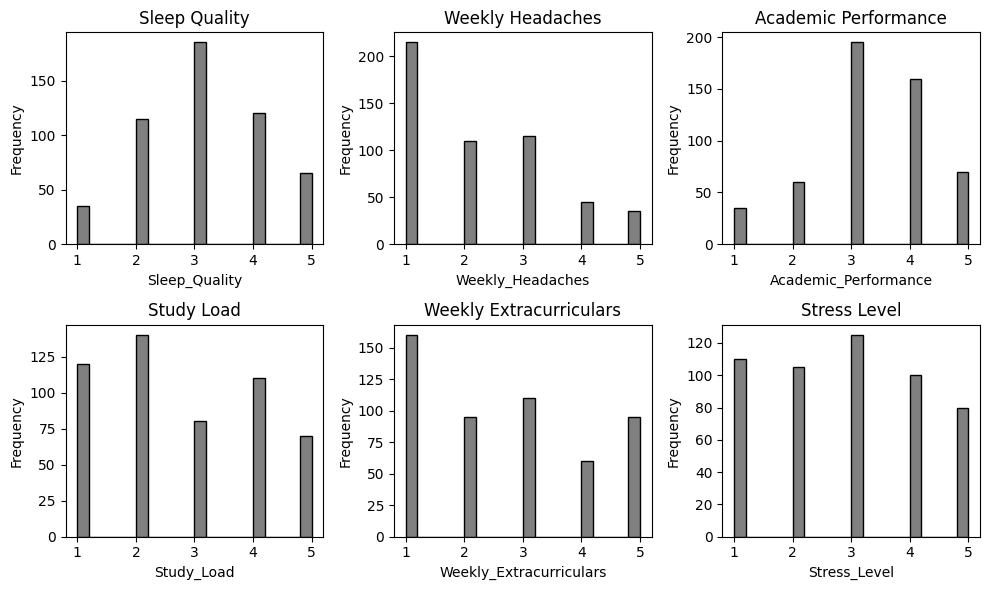

In [21]:
# Set number of columns in the grid
data_to_plot = data
n_cols = 3
n_rows = int(np.ceil(len(data_to_plot.columns) / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
axes = axes.flatten()  # Flatten in case it's 2D

# Plot histograms
for i, col in enumerate(data_to_plot.columns):
    axes[i].hist(data_to_plot[col], bins=20, color='grey', edgecolor='black')
    axes[i].set_title(f'{col.replace("_", " ")}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Factor Analysis

### Factor Analysis Pre-Work

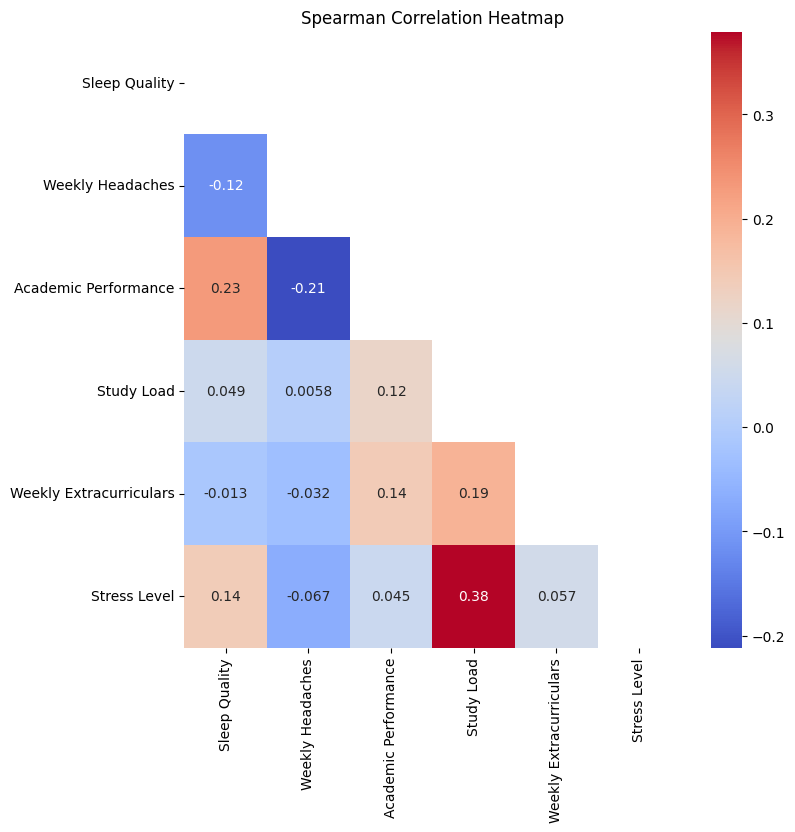

In [22]:
# Compute Spearman correlation matrix
corr, _ = spearmanr(data_scaled)

corr_subset = corr[:6, :6]
labels = list(map(lambda x: x.replace("_", " "), data_encoded.columns))
labels_subset = labels[:6]
mask = np.triu(np.ones_like(corr_subset, dtype = bool))

# Create a heatmap
# labels = list(map(lambda x: x.replace("_", " "), data_encoded.columns))
plt.figure(figsize=(8, 8))
sns.heatmap(corr_subset, mask = mask, annot=True, xticklabels=labels_subset, yticklabels=labels_subset, cmap="coolwarm")
plt.title('Spearman Correlation Heatmap')
plt.show()

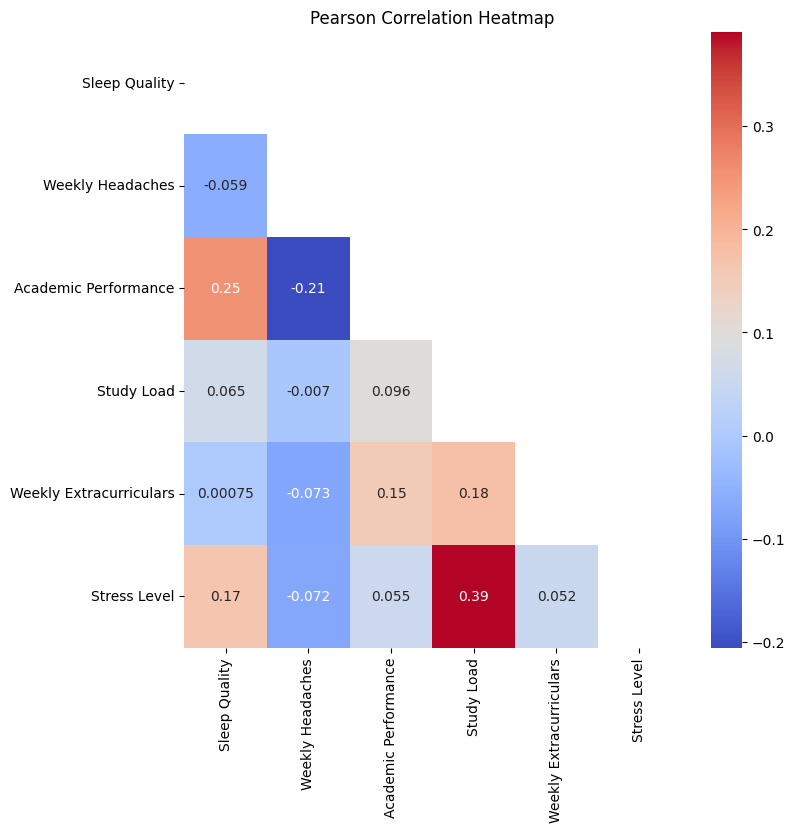

In [23]:
# Compute Pearson correlation matrix
data_scaled_df = pd.DataFrame(data_scaled, columns=data_encoded.columns)
corr = data_scaled_df.corr(method='pearson')

corr_subset = corr.iloc[:6, :6]
labels = list(map(lambda x: x.replace("_", " "), data_encoded.columns))
labels_subset = labels[:6]
mask = np.triu(np.ones_like(corr_subset, dtype = bool))

# Create a heatmap
# labels = list(map(lambda x: x.replace("_", " "), data_encoded.columns))
plt.figure(figsize=(8, 8))
sns.heatmap(corr_subset, mask = mask, annot=True, xticklabels=labels_subset, yticklabels=labels_subset, cmap="coolwarm")
plt.title('Pearson Correlation Heatmap')
plt.show()

### Factor Analysis Fits

In [24]:
# Step 1: Standardize the data (mean centering)
X_mean = np.mean(corr_subset, axis=0)
X_centered = corr_subset - X_mean

# Step 2: Compute the covariance matrix
cov_matrix = np.cov(X_centered, rowvar=False)

# Step 3: Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Step 4: Sort eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

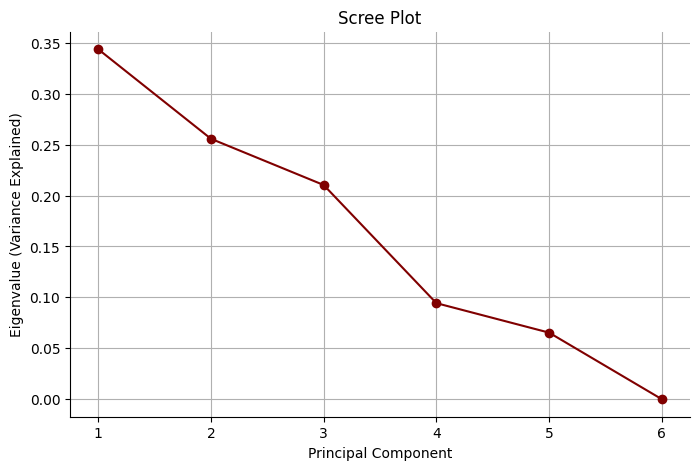

In [25]:
# Scree plot ("explained variance" by each principal component)
f, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(range(1, len(sorted_eigenvalues) + 1), sorted_eigenvalues, marker='o', linestyle='-', color="maroon")
ax.set_xlabel('Principal Component')
ax.set_ylabel('Eigenvalue (Variance Explained)')
ax.set_title('Scree Plot')
ax.grid(True)
sns.despine(ax=ax)

### Factor Analysis Evaluations

### Clustering Analysis

In [ ]:
# set up k means clustering
k = 6

initial_centroids = tf.random.shuffle(corr_subset)
centroids = tf.Variable(initial_centroids)

def assign_to_clusters(corr_subset, centroids):
    expanded_data = tf.expand_dims(corr_subset, 0) 
    expanded_centroids = tf.expand_dims(centroids, 1)
    distances = tf.reduce_sum(tf.square(expanded_data - expanded_centroids), 2)
    assignments = tf.argmin(distances, 0)
    return assignments

assignments = assign_to_clusters(corr_subset, centroids)

def update_centroids(corr_subset, assignments, k):
    means = []
    for i in range(k):
        mask = tf.equal(assignments, i)
        cluster_data = tf.boolean_mask(corr_subset, mask)
        mean = tf.reduce_mean(cluster_data, axis=0)
        means.append(mean)
    new_centroids = tf.stack(means)
    return new_centroids

new_centroids = update_centroids(corr_subset, assignments, k)


for _ in range(10): # Number of iterations
    assignments = assign_to_clusters(corr_subset, centroids)
    centroids.assign(update_centroids(corr_subset, assignments, k))

print("Cluster Assignments:", assignments.numpy())
print("Final Centroids:", centroids.numpy())

Cluster Assignments: [3 1 0 2 5 4]
Final Centroids: [[ 0.25401594 -0.20531612  1.          0.0959215   0.15301529  0.05516107]
 [-0.05885106  1.         -0.20531612 -0.00703415 -0.073362   -0.0718065 ]
 [ 0.0654704  -0.00703415  0.0959215   1.          0.17540739  0.39162162]
 [ 1.         -0.05885106  0.25401594  0.0654704   0.00074502  0.16543058]
 [ 0.16543058 -0.0718065   0.05516107  0.39162162  0.05246269  1.        ]
 [ 0.00074502 -0.073362    0.15301529  0.17540739  1.          0.05246269]]


c:\Users\malanr\anaconda3\envs\behavioral-data-science\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\malanr\anaconda3\envs\behavioral-data-science\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\malanr\anaconda3\envs\behavioral-data-science\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\malanr\anaconda3\envs\behavioral-data

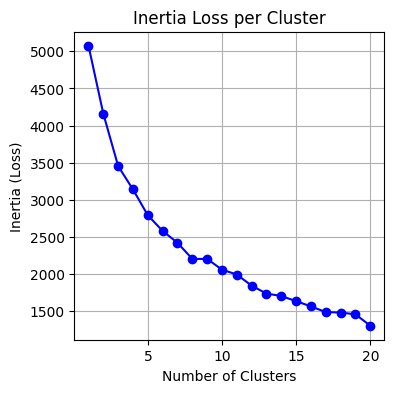

In [31]:
# scikit this

inertias = []
k_values = range(1, 21)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(4,4))
plt.plot(k_values, inertias, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Loss)')
plt.title('Inertia Loss per Cluster')
plt.grid(True)
plt.show()

## Regression Models

### Regression Model Fits

### Regression Model Evaluations